<a href="https://colab.research.google.com/github/Seife1/ML_Capstone_Project/blob/main/Locust_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Locust Detection**

**Explore the process of building a simple, yet effective, Convolutional Neural Network from scratch. For this task, We will use Keras to help us build a neural network that can accurately identify Locust from other flying creatures through images.**

In [ ]:
# Importing Libraries

# Data Handling
# import pandas as pd
import numpy as np
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

# To display the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Randomizer
import random

# OS
import os

# Image package
from PIL import Image

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

# Data Visualization
from IPython.display import display
import ipywidgets as widgets


In [ ]:
# Importing Keras
from keras.models import Sequential                          # Neural network model as a sequence of layers.
from keras.layers import Conv2D                              # Convolutional layer
from keras.layers import MaxPooling2D                        # Max pooling layer
from keras.layers import Flatten                             # Layer used to flatten 2D arrays for fully-connected layers.
from keras.layers import Dense                               # This layer adds fully-connected layers to the neural network.
from keras.layers import Dropout                             # This serves to prevent overfitting by dropping out a random set of activations.
from keras.layers import BatchNormalization                  # This is used to normalize the activations of the neurons.
from keras.layers import Activation                          # Layer for activation functions
from keras.callbacks import EarlyStopping, ModelCheckpoint   # Classes used to save weights and stop training when improvements reach a limit
from keras.models import load_model                          # This helps us to load trained models
# Preprocessing layers
from keras.preprocessing import image
from keras.layers import Rescaling                           # This layer rescales pixel values

# Importing TensorFlow
import tensorflow as tf

In [ ]:
# Configuring notebook
seed = 123
paper_color = '#EEF6FF'
bg_color = '#EEF6F7'
#colormap =
#template =

In [ ]:
def image_resizer(paths):
    """
    This function resizes the input images
    """
    with ThreadPoolExecutor() as executor:
        resized_images = list(executor.map(lambda x: Image.open(x).resize((350,250)), paths))
    return resized_images

def plot_images_list(images_list, title, dataset_name):
  """
  This function plots a list of images with the given title and dataset name.

  Args:
    images_list: A list of image file paths.
    title: The title of the plot.
    dataset_name: The name of the dataset.
  """

  plt.figure(figsize=(10, 10))
  plt.title(f"{title}\n{dataset_name}")

  for i in range(len(images_list)):
    plt.subplot(5, 5, i + 1)
    img = mpimg.imread(images_list[i])
    plt.imshow(img)
    plt.axis("off")

  plt.show()

In [ ]:
# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
        print('\nGPU Found! Using GPU...')
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)


GPU Found! Using GPU...


In order to upload a folder in Google Colab, you need to first ***mount your Google Drive***. This will allow you to access your files and folders in Google Drive directly from Colab.

To mount your Google Drive, run the following code in a code cell:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading training, testing, and validation directories
train_dir = '/content/drive/MyDrive/Colab Notebooks/ML Path/MachineLearning/Train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/ML Path/MachineLearning/Test'
val_dir = '/content/drive/MyDrive/Colab Notebooks/ML Path/MachineLearning/Validate'

In [ ]:
# Giving names to each directory
directories = {
    train_dir: 'Train',
    test_dir: 'Test',
    val_dir: 'Validation'
    }

# Naming subfolders
subfolders = ['Locust', 'NonLocust']

print('\n* * * * * Number of files in each folder * * * * *\n')

# Counting the total of pictures inside each subfolder and directory
for dir, name in directories.items():
    total = 0
    for sub in subfolders:
        path = os.path.join(dir, sub)
        num_files = len([f for f in os.listdir(path) if os.path.join(path, f)])
        total += num_files
        print(f'\n{name}/{sub}: {num_files}')
    print(f'\n  Total: {total}')
    print("-" * 80)


* * * * * Number of files in each folder * * * * *


Train/Locust: 2768

Train/NonLocust: 2767

  Total: 5535
--------------------------------------------------------------------------------

Test/Locust: 305

Test/NonLocust: 329

  Total: 634
--------------------------------------------------------------------------------

Validation/Locust: 109

Validation/NonLocust: 110

  Total: 219
--------------------------------------------------------------------------------


Convolutional Neural Networks require a **`fixed size for all images`** we feed into it. This means that every single image in our dataset must be equally sized.

We can also check if our data meets this requirement, or if it will be
necessary to perform some preprocessing in this regard before modeling.

In [ ]:
unique_dimensions = set()

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                unique_dimensions.add(img.size)

if len(unique_dimensions) == 1:
    print(f"\nAll images have the same dimensions: {unique_dimensions.pop()}")
else:
    print(f"\nFound {len(unique_dimensions)} unique image dimensions: {unique_dimensions}")


Found 971 unique image dimensions: {(744, 557), (1024, 840), (392, 273), (1024, 849), (817, 645), (635, 516), (1024, 867), (715, 1024), (792, 728), (906, 750), (262, 270), (1024, 705), (678, 724), (247, 138), (1023, 1024), (1024, 714), (750, 600), (502, 260), (772, 1024), (928, 1024), (532, 1024), (350, 230), (1024, 732), (1024, 970), (287, 439), (1024, 741), (900, 773), (523, 557), (1024, 988), (670, 1003), (1024, 570), (985, 1024), (248, 218), (938, 903), (1382, 1465), (1024, 588), (416, 458), (1024, 826), (966, 754), (734, 1024), (628, 1024), (1024, 835), (1640, 1104), (1024, 844), (870, 1024), (1024, 853), (780, 749), (620, 620), (802, 1024), (600, 800), (435, 327), (879, 880), (524, 652), (927, 1024), (1024, 700), (1024, 471), (1024, 709), (283, 455), (832, 1024), (839, 682), (1024, 718), (638, 512), (1024, 956), (375, 309), (1024, 965), (764, 1024), (872, 697), (1024, 974), (497, 262), (1024, 556), (536, 482), (516, 275), (577, 770), (1024, 565), (900, 1024), (1024, 574), (536, 

In the next cell, I am going to check the distribution of these dimensions across the data.

In [ ]:
# Checking if all the images in the dataset have the same dimensions
dims_counts = defaultdict(int)

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                dims_counts[img.size] += 1

for dimension, count in dims_counts.items():
    print(f"\nDimension {dimension}: {count} images")


Dimension (300, 300): 3182 images

Dimension (625, 751): 1 images

Dimension (498, 1024): 29 images

Dimension (1024, 768): 423 images

Dimension (1024, 767): 14 images

Dimension (768, 1024): 740 images

Dimension (1024, 777): 2 images

Dimension (1024, 576): 37 images

Dimension (1024, 758): 6 images

Dimension (637, 1024): 1 images

Dimension (1024, 1024): 118 images

Dimension (473, 1024): 3 images

Dimension (1024, 680): 15 images

Dimension (576, 1024): 73 images

Dimension (1024, 1021): 2 images

Dimension (1008, 1024): 3 images

Dimension (620, 620): 1 images

Dimension (572, 573): 1 images

Dimension (735, 687): 1 images

Dimension (1024, 471): 7 images

Dimension (995, 1024): 2 images

Dimension (636, 636): 1 images

Dimension (683, 1024): 34 images

Dimension (640, 480): 2 images

Dimension (1024, 783): 2 images

Dimension (1024, 907): 1 images

Dimension (1024, 761): 5 images

Dimension (1024, 908): 1 images

Dimension (1024, 683): 276 images

Dimension (1024, 681): 23 ima

It seems that most images have dimensions of  300*300 about 3182 images out of 6380 images
 , which means most image have a rectangular shape. We can conclude that, due to the differences in dimensions, we will need to apply some preprocessing to the data.

First, we are going to resize the images, so they all have the same shape. Then, we will transform the input from rectangular shape to square shape.

Another crucial consideration is verifying the pixel value range of the images. In this case, all images should have pixel values spanning from 0 to 255. This consistency simplifies the preprocessing step, since we often normalize pixel values in images to a range going from 0 to 1.

In [ ]:
# Checking images dtype
all_uint8 = True
all_in_range = True

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                img_array = np.array(img)

            if img_array.dtype == 'uint8':
                all_uint8 = False

            if img_array.min() < 0 or img_array.max() > 255:
                all_in_range = False

if all_uint8:
    print(" - All images are of data type uint8\n")
else:
    print(" - Not all images are of data type uint8\n")

if all_in_range:
    print(" - All images have pixel values ranging from 0 to 255")
else:
    print(" - Not all images have the same pixel values from 0 to 255")

 - Not all images are of data type uint8

 - All images have pixel values ranging from 0 to 255


Even though not all images are of the same data type, uint8, it is fairly easy to guarantee that they will have the same data type once we load images into datasets. We confirmed, though, that all the images have pixel values ranging from 0 to 255, which is great news.

Before moving on to the **Preprocessing step**, let's plot some images from each class to see what they look like.

In [ ]:
# Loading the directory for each class in the training dataset
train_locust_dir = train_dir + "/" + 'Locust'
train_nonLocust_dir = train_dir + "/" + 'NonLocust'

# Selecting 9 random pictures from each directory
locust_files = random.sample(os.listdir(train_locust_dir), 20)
nonLocust_files = random.sample(os.listdir(train_nonLocust_dir), 20)

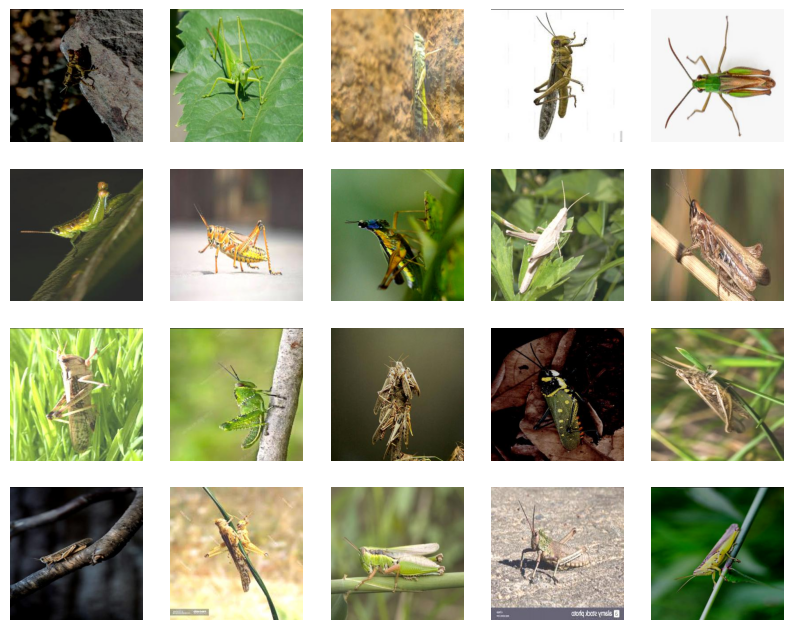

In [ ]:
# Plotting Locust images
locust_images = [os.path.join(train_locust_dir, f) for f in locust_files]
plot_images_list(locust_images, "Locust", "Training Dataset")

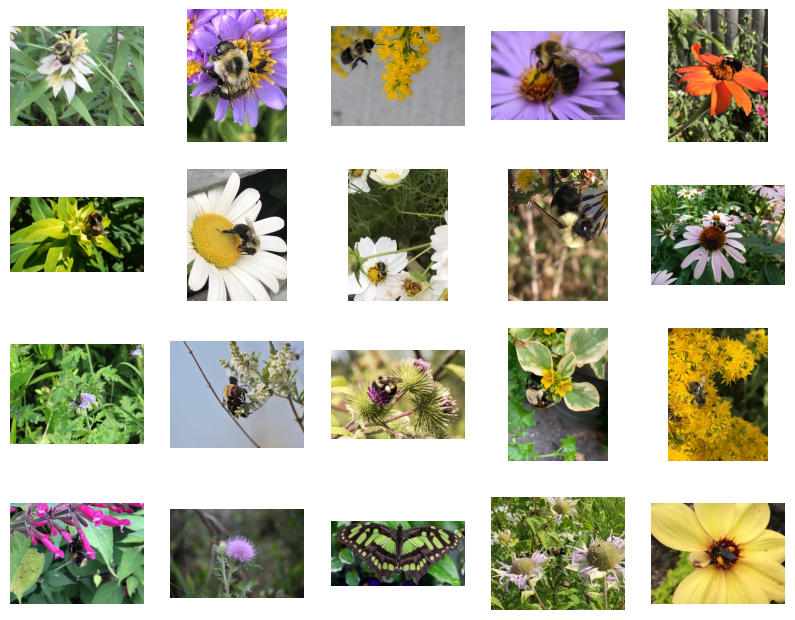

In [ ]:
# Plotting Non Locust images
nonLocust_images = [os.path.join(train_nonLocust_dir, f) for f in nonLocust_files]
plot_images_list(nonLocust_images, "Non Locust", "Training Dataset")

# **Preprocessing**

In [ ]:
# Creating a Dataset for the Training data
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,  # Directory where the Training images are located
    labels = 'inferred', # Classes will be inferred according to the structure of the directory
    label_mode = 'categorical',
    class_names = ['Locust', 'NonLocust'],
    batch_size = 16,    # Number of processed samples before updating the model's weights
    image_size = (256, 256), # Defining a fixed dimension for all images
    shuffle = True,  # Shuffling data
    seed = seed,  # Random seed for shuffling and transformations
    validation_split = 0, # We don't need to create a validation set from the training set
    crop_to_aspect_ratio = True # Resize images without aspect ratio distortion
)

Found 5535 files belonging to 2 classes.


In [ ]:
# Creating a dataset for the Test data
test = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['Locust', 'NonLocust'],
    batch_size = 16,
    image_size = (256, 256),
    shuffle = True,
    seed = seed,
    validation_split = 0,
    crop_to_aspect_ratio = True
)

Found 634 files belonging to 2 classes.


In [ ]:
# Creating a dataset for the Validation data
validation = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['Locust', 'NonLocust'],
    batch_size = 16,
    image_size = (256, 256),
    shuffle = True,
    seed = seed,
    validation_split = 0,
    crop_to_aspect_ratio = True
)

Found 219 files belonging to 2 classes.


### **Print these datasets for a further understanding of their structure.**

In [ ]:
print('\nTraining Dataset:', train)
print('\nTesting Dataset:', test)
print('\nValidation Dataset:', validation)


Training Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

Testing Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


In [ ]:
# Checking minimum and maximum pixel values in the Validation dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in validation:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 255.0


To bring the pixel values to the **0 to 1** range, we can easily use one of Keras' preprocessing layers,
`tf.keras.layers.Rescaling`

In [ ]:
scaler = Rescaling(1./255) # Defining scaler values between 0 to 1

# Rescaling datasets
train = train.map(lambda x, y: (scaler(x), y))
test = test.map(lambda x, y: (scaler(x), y))
validation = validation.map(lambda x, y: (scaler(x), y))

In [ ]:
# Checking minimum and maximum pixel values in the Validation dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in validation:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 1.0


# **Data Augmentation**

Applying random transformations to the images used in training. This is good because it helps to expose the model to a wider variety of images and avoids overfitting.

In [ ]:
# Creating data augmentation pipeline
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(
        factor = (-.25, .3),
        fill_mode = 'reflect',
        interpolation = 'bilinear',
        seed = seed),


        tf.keras.layers.RandomBrightness(
        factor = (-.45, .45),
        value_range = (0.0, 1.0),
        seed = seed),

        tf.keras.layers.RandomContrast(
        factor = (.5),
        seed = seed)
    ]
)

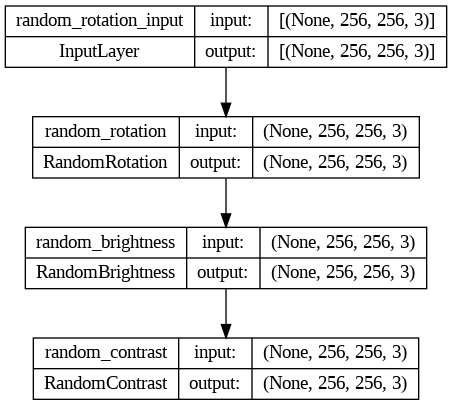

In [ ]:
augmentation.build((None, 256, 256, 3)) # Building model
# Plotting model
tf.keras.utils.plot_model(augmentation,
                          show_shapes = True,
                          show_layer_names = True,
                          expand_nested = True)

# **Building the Convolutional Neural Network**

### **Layers used to the network**


*   **Convolution**
*   **Pooling**
*   **Fully Connected**


---


* Batch Normalization
* Dropout
* Flatten


In [ ]:
# Initiating model on GPU
with strategy.scope():
    model = Sequential()

    model.add(augmentation) # Adding data augmentation pipeline to the model

    # Feature Learning Layers
    model.add(Conv2D(32,                  # Number of filters/Kernels
                     (3,3),               # Size of kernels (3x3 matrix)
                     strides = 1,         # Step size for sliding the kernel across the input (1 pixel at a time).
                     padding = 'same',    # 'Same' ensures that the output feature map has the same dimensions as the input by padding zeros around the input.
                    input_shape = (256,256,3) # Input image shape
                    ))
    model.add(Activation('relu'))# Activation function
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    # Flattening tensors
    model.add(Flatten())

    # Fully-Connected Layers
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(2, activation = 'softmax')) # Classification layer

By using Keras' `compile` method, we can prepare our neural network for training.

In [ ]:
# Compiling model RMSprop
model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), # 1e-4
              loss = 'binary_crossentropy', # Ideal for binary class tasks
              metrics = ['accuracy']) # Evaluation metric

In [ ]:
# Defining an Early Stopping and Model Checkpoints

early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5, mode = 'max',
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model.h5',
                            monitor = 'val_accuracy',
                            save_best_only = True)

## Start Model Training and Testing process

In [ ]:
# Training and Testing Model
try:
    history = model.fit(
        train, epochs = 50,
        validation_data = test,
        callbacks = [early_stopping, checkpoint])
except Exception as e:
    print("An error occurred:", e)

Epoch 1/50
346/346 [==============================] - 79s 184ms/step - loss: 1.1621 - accuracy: 0.6800 - val_loss: 2.3642 - val_accuracy: 0.4842
Epoch 2/50
346/346 [==============================] - 66s 188ms/step - loss: 0.5299 - accuracy: 0.7637 - val_loss: 1.9891 - val_accuracy: 0.6230
Epoch 3/50
346/346 [==============================] - 56s 158ms/step - loss: 0.4638 - accuracy: 0.7872 - val_loss: 1.1692 - val_accuracy: 0.6451
Epoch 4/50
346/346 [==============================] - 64s 183ms/step - loss: 0.4150 - accuracy: 0.8139 - val_loss: 0.7245 - val_accuracy: 0.7950
Epoch 5/50
346/346 [==============================] - 60s 171ms/step - loss: 0.3526 - accuracy: 0.8473 - val_loss: 0.9146 - val_accuracy: 0.8233
Epoch 6/50
346/346 [==============================] - 60s 171ms/step - loss: 0.3096 - accuracy: 0.8672 - val_loss: 0.6231 - val_accuracy: 0.8738
Epoch 7/50
346/346 [==============================] - 62s 177ms/step - loss: 0.2903 - accuracy: 0.8768 - val_loss: 0.5298 - val_ac

Based on this output, you can see that the model's loss is decreasing and its accuracy is increasing on both the training and validation datasets as it trains. This indicates that the model is learning and improving its performance.
#### The highest accuracy for the testing set has been reached at the 21st epoch at **0.9290**, or **92.90%,** and didn't improve after that.
With the history object, we can plot lineplots showing both the loss function and accuracy for both sets over epochs.


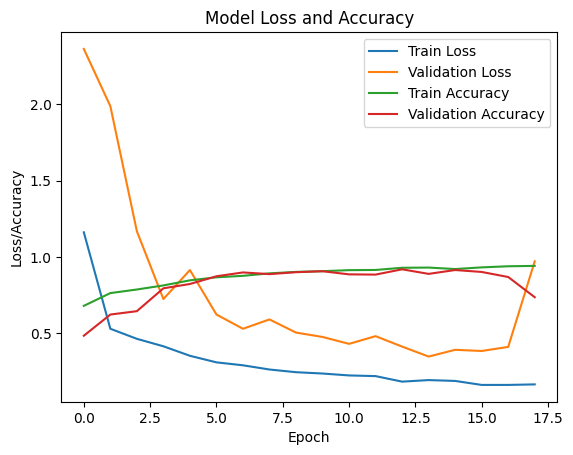

In [ ]:
# Plot the loss for both sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Plot the accuracy for both sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Add labels and title
plt.title('Model Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')

# Show the plot
plt.legend(['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy'])
plt.show()

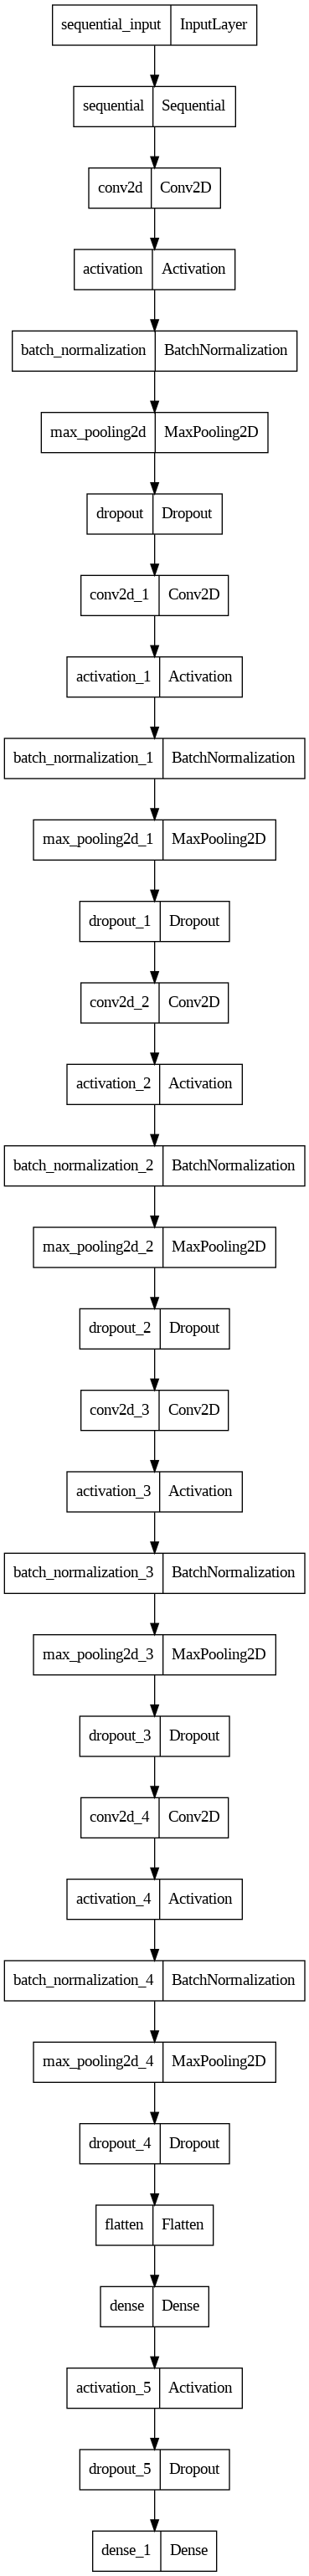

In [ ]:
tf.keras.utils.plot_model(model) # Plotting model

In [ ]:
model.summary() # Printing model summary

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)     

# **Validating Performance**

In [ ]:
# Loading best weights
model.load_weights('best_model.h5')

In [ ]:
preds = model.predict(validation)  # Running model on the validation dataset
val_loss, val_acc = model.evaluate(validation) # Obtaining Loss and Accuracy on the val dataset

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

14/14 [==============================] - 2s 65ms/step - loss: 0.4514 - accuracy: 0.9224

Validation Loss:  0.45140936970710754

Validation Accuracy:  92.0 %


Picture of a Locust Plant: 



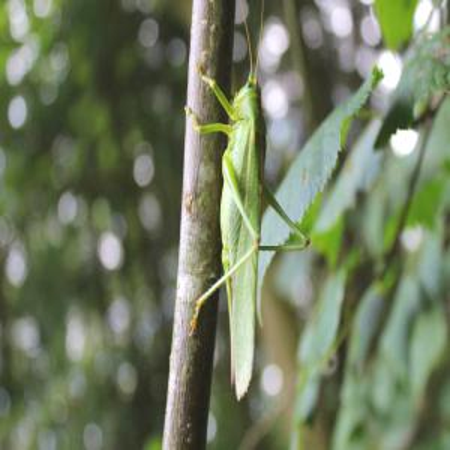

In [ ]:
# Loading an image from the Validation/ Locust directory
#g--574-_jpg.rf.98f5658d57629f3608da18f09a868532.jpg
image_path = '/content/drive/MyDrive/Colab Notebooks/ML Path/MachineLearning/Validate/Locust/g--574-_jpg.rf.98f5658d57629f3608da18f09a868532.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * 1.5) # 150% of the original size
new_height = int(og_height * 1.5) # 150% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a Locust Plant: \n')
resized_img

In [ ]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['Locust', 'NonLocust']

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

1/1 [==============================] - 1s 626ms/step

Predicted Class: Locust

Confidence Score: 0.9999986886978149


Picture of Non Locust: 



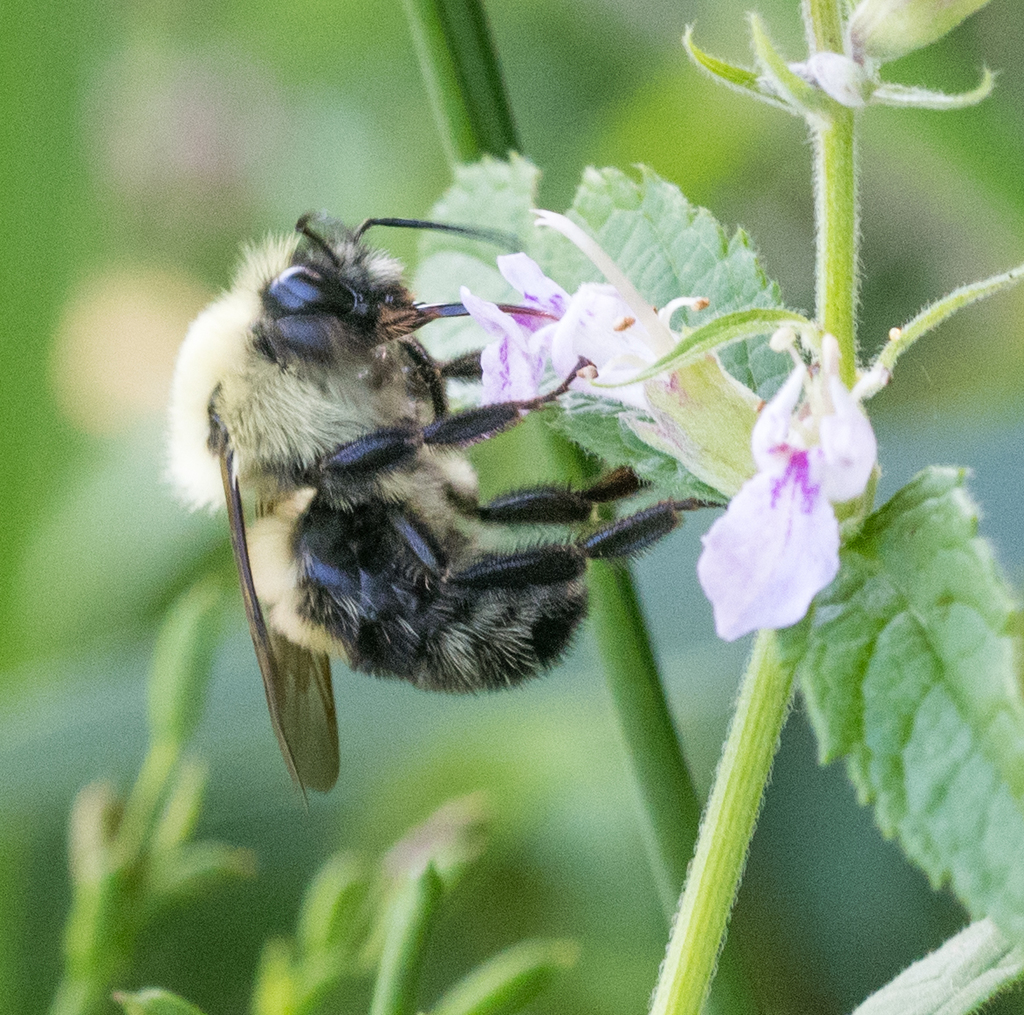

In [ ]:
# Loading an image from the Validation/ NonLocust directory
# Two-spotted_Bumble_Bee_Bombus_bimaculatus_9801.jpg
image_path = '/content/drive/MyDrive/Colab Notebooks/ML Path/MachineLearning/Validate/NonLocust/Two-spotted_Bumble_Bee_Bombus_bimaculatus_9801.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * 1) # 150% of the original size
new_height = int(og_height * 1) # 150% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of Non Locust: \n')
resized_img

In [ ]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['Locust', 'NonLocust']


preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

1/1 [==============================] - 0s 90ms/step

Predicted Class: Locust

Confidence Score: 0.8960936069488525


In [ ]:
model.save('Locust_Detection.h5') # Saving model

In [ ]:
from pathlib import Path

path = Path()
files = path.glob('*.h5')

for file in files:
    print(file)

best_model.h5
Locust_Detection.h5


In [ ]:
!pwd

/content


In [ ]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.3/383.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter-se

In [ ]:
# Check if the file exists in the current directory
if not os.path.exists("Locust_Detection.h5"):
    raise FileNotFoundError("Model file 'Locust_Detection.h5' not found.")


In [ ]:
# Load your model
model = load_model("./Locust_Detection.h5")

# Create UI elements
btn_run = widgets.Button(description='Classify')
btn_upload = widgets.FileUpload(accept='image/*')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

import uuid
import io

def generate_unique_filename():
    return str(uuid.uuid4())

def on_click_classify(change):
  if btn_upload.value:
    # Load the image
    uploaded_file = list(btn_upload.value.values())[0]
    img_data = uploaded_file['content']
    img = Image.open(io.BytesIO(img_data))

    # Check if the image has 4 channels and convert it to 3 channels if necessary
    if img.mode == 'RGBA':
        img = img.convert('RGB')

    # Preprocess the image
    img = img.resize((256, 256))  # Adjust size according to your model input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to [0, 1] if required by your model

    # Predict the class
    predictions = model.predict(img_array)
    pred_class = np.argmax(predictions, axis=1)
    labels = ['Locust', 'NonLocust']
    preds_label = labels[pred_class[0]]
    confidence_score = predictions[0][pred_class[0]]

    # Display results
    out_pl.clear_output()
    with out_pl:
        display(img)
        lbl_pred.value = f'Predicted Class: {preds_label}\nConfidence Score: {confidence_score:.4f}'
  else:
        lbl_pred.value = 'No image uploaded. Please upload an image.'

btn_run.on_click(on_click_classify)

# Display the UI
display(widgets.VBox([widgets.Label('Select your images!'),
                      btn_upload, btn_run, out_pl, lbl_pred]))

In [ ]:
!pip install pyngrok

In [ ]:
# from pyngrok import ngrok

# # Run Voila
# def start_voila(port):
#     from subprocess import Popen
#     Popen(['voila', '--no-browser', '--port', str(port), '--Voila.ip=0.0.0.0'])

# port = 5050
# start_voila(port)

# # Create a tunnel to the Voila app
# public_url = ngrok.connect(port)
# print(f'Voila public URL: {public_url}')
